***

# **STA 221 Project Code**

***

## EDA

In [1]:
# Packages

# For all sklearn optimization
# Turn on scikit-learn optimizations with these 2 simple lines:
from sklearnex import patch_sklearn
patch_sklearn()

import time
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# For Wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import string
import re
from collections import Counter

# Logistic Regression 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cross Validation
from sklearn.model_selection import GridSearchCV

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
tweets = pd.read_csv("Tweets.csv")

In [3]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Cleaning

In [4]:
# Cleaning http links in Dataframes
url_pattern = r'http[s]?://\S+'

# Replace URLs with an empty string
tweets['text'] = tweets['text'].str.replace(url_pattern, '', regex=True)
#tweets[tweets["text"].str.contains("http")]
#tweets.shape

tweets.drop_duplicates(subset = "text", keep = "last", inplace = True)

### Graphs

In [5]:
# Company Logo color (or at least one of them) is mapped to each Airline respetively.
color_discrete_map = {
    "American": "#00a9e0",
    "United": "#005DAA",
    "Southwest": "#F9B612",
    "Delta": "#c8102e",
    "US Airways": "#bdc1c4",
    "Virgin America": "#5b056a"
}

# Plotting number of tweets per each sentiment per each airline
px.histogram(
    data_frame=tweets,
    x="airline_sentiment",
    color="airline",
    title="Sentiment Labels of Tweets by Airlines",
    labels={"airline_sentiment": "Sentiment of Tweet"},
    color_discrete_map=color_discrete_map,
).update_xaxes(categoryorder = "total descending")

In [6]:
# Retweets are very 0 inflated
px.histogram(data_frame=tweets,
    x="retweet_count")

In [7]:
# Looking at Reason per airline for all negative reviews
px.histogram(
    data_frame=tweets,
    x="negativereason",
    color="airline",
    title="Reason for Negative Tweets by Airline",
    labels={"negativereason": "Reason for Negative Tweet"},
    color_discrete_map=color_discrete_map,  
).update_xaxes(categoryorder = "total descending")

### WordCloud

### Functions

In [9]:
def count_frequent_words(s, min_count=10):
    # Remove words that start with 'http'
    s = re.sub(r"\bhttp\S*", "", s)

    # Normalize the string: convert to lowercase and remove punctuation
    normalized_string = s.lower().translate(str.maketrans("", "", string.punctuation))

    # Split the string into words
    words = normalized_string.split()

    # Count words and filter those that appear at least 'min_count' times
    word_count = Counter(words)


    frequent_words = {
        word: count for word, count in word_count.items() if count >= min_count
    }

    # Get the number of unique words that show up greater than or equal too min count
    num_unique_words = len(set(frequent_words))

    return num_unique_words, frequent_words

def talk_clean_to_me(string_vec):
    # Remove words that start with 'http'
    string_vec = re.sub(r"\bhttp\S*", "", string_vec)

    # Normalize the string: convert to lowercase and remove punctuation
    normalized_string = string_vec.lower().translate(str.maketrans("", "", string.punctuation))

    return string_vec


def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Plotly Express.

    Parameters:
    cm (array-like): The confusion matrix.
    class_names (list of str): List containing the names of the classes.
    """
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    fig = px.imshow(cm_df,
                    labels=dict(x="Predicted Label", y="True Label", color="Count"),
                    x=class_names,
                    y=class_names,
                    text_auto=True)

    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        xaxis = dict(tickangle=45),
        yaxis = dict(tickangle=45)
    )

    fig.show()


def plot_confusion_matrix_with_table(cm, class_names):
    """
    Creates a subplot with a confusion matrix heatmap and a table.
    
    Parameters:
    cm (array-like): The confusion matrix.
    class_names (list of str): List containing the names of the classes.
    """
    # Create a DataFrame from the confusion matrix for the table
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Initialize subplots: one for heatmap, one for table
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.7, 0.3],
        subplot_titles=("Confusion Matrix", "Data"),
        specs=[[{"type": "heatmap"}, {"type": "table"}]]
    )

    # Add heatmap to the first subplot
    fig.add_trace(
        go.Heatmap(
            z=cm_df,
            x=class_names,
            y=class_names,
            showscale=True,
            text=cm_df.values,
            texttemplate="%{text}",
            textfont={"size":12}
        ),
        row=1, col=1
    )

    # Add table to the second subplot
    table_data = cm_df.reset_index().values.tolist()
    table_data.insert(0, [""] + class_names)
    fig.add_trace(
        go.Table(
            header=dict(values=[""] + class_names),
            cells=dict(values=list(zip(*table_data)))
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Confusion Matrix with Data Table",
        height=500, width=1000
    )

    fig.show()

def plot_confusion_matrix_with_classification_report(cm, class_names, y_true, y_pred, fig_width=1200, fig_height=500):
    """
    Creates a subplot with a confusion matrix heatmap and a classification report table.
    
    Parameters:
    cm (array-like): The confusion matrix.
    class_names (list of str): List containing the names of the classes.
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    fig_width (int): Width of the figure (default 1000).
    fig_height (int): Height of the figure (default 500).
    """
    # Create a DataFrame from the confusion matrix for the heatmap
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Generate classification report and convert it to a DataFrame
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(2)  # Optional rounding

    # Initialize subplots
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.6, 0.4],
        subplot_titles=("Confusion Matrix", "Classification Report"),
        specs=[[{"type": "heatmap"}, {"type": "table"}]]
    )

    # Add heatmap to the first subplot
    fig.add_trace(
        go.Heatmap(
            z=cm_df,
            x=class_names,
            y=class_names,
            showscale=True,
            colorscale = "Inferno",
            text=cm_df.values,
            texttemplate="%{text}",
            textfont={"size":12}
        ),
        row=1, col=1
    )

    # Add table (classification report) to the second subplot
    fig.add_trace(
        go.Table(
            header=dict(values=list(report_df.columns), fill_color='rgba(0,0,0,0)'),
            cells=dict(values=[report_df.index] + [report_df[k].tolist() for k in report_df.columns], fill_color='rgba(0,0,0,0)')
        ),
        row=1, col=2
    )

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
      # Add accuracy annotation
    fig.add_annotation(
        dict(
            font=dict(color='rgba(247, 247, 247, 1)', size=16),
            x= 0.9, #0.5,
            y= 0.1, #-0.15,
            showarrow=False,
            text="Overall Accuracy: {:.2%}".format(accuracy),
            xref="paper",
            yref="paper"
        )
    )

    # Update layout
    fig.update_layout(
        title_text="Confusion Matrix with Classification Report",
        height=fig_height, width=fig_width,
        paper_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        font=dict(color='rgba(247, 247, 247, 1)') #off_white
    )

    fig.show()


def remove_background_from_wordcloud(wordcloud, background_color=(255, 255, 255)):
    """
    This was annoying:
    Removes the specified background color from a WordCloud object, making it transparent.
    
    Parameters:
    wordcloud (WordCloud): The WordCloud object.
    background_color (tuple): RGB tuple of the background color to make transparent.

    Returns:
    PIL.Image: An image object with the background made transparent.
    """
    # Convert the word cloud to a PIL Image
    wordcloud_image = wordcloud.to_image()

    # Convert the image to RGBA
    wordcloud_rgba = wordcloud_image.convert("RGBA")

    # Convert to numpy array
    data = np.array(wordcloud_rgba)

    # Identify all pixels matching the background color
    r, g, b, a = data.T
    background_areas = (r == background_color[0]) & (g == background_color[1]) & (b == background_color[2])

    # Make these pixels fully transparent
    data[..., -1][background_areas.T] = 0

    # Convert back to PIL Image and return
    return Image.fromarray(data)

In [49]:
# Get one list
tweet_list = tweets["text"].tolist()

# Combine all tweets into a single string
all_tweets = " ".join(tweet_list)

# Load the plane image
plane_mask = np.array(Image.open("plane_image2.jpg"))
#plane_mask = np.array(Image.open("plane_image22.png"))
#plane_mask_image = Image.open("plane_image22.png")
#plane_mask = plane_mask_image.convert("RGBA")
#plane_mask_grayscale = plane_mask_image.convert("L")  # Convert to grayscale
#plane_mask = np.array(plane_mask)

# color_list = np.array(['#b5d6e0',  '#ffef7a', '#f7c16a', '#ff6b3e', '#27214e'])

# Define a list of words to exclude
# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(
    [
        "the",
        "and",
        "to",
        "of",
        "a",
        "in",
        "for",
        "on",
        "is",
        "with",
        "that",
        "by",
        "this",
        "it",
        "as",
        "are",
        "be",
        "was",
        "from",
        "at",
        "will",
        "your",
        "but",
        "http",
        "you",
    ]
)

In [37]:
# Load the silhouette image
plane_mask_image = Image.open("plane_image22.png")

# Convert the image to grayscale
plane_mask_grayscale = plane_mask_image.convert("L")

# Convert to numpy array
plane_mask_array = np.array(plane_mask_grayscale)

# The mask should have values of 255 where the plane shape is, and 0 elsewhere
# You might need to invert the mask depending on the image
plane_mask_array = np.where(plane_mask_array > 128, 255, 0)

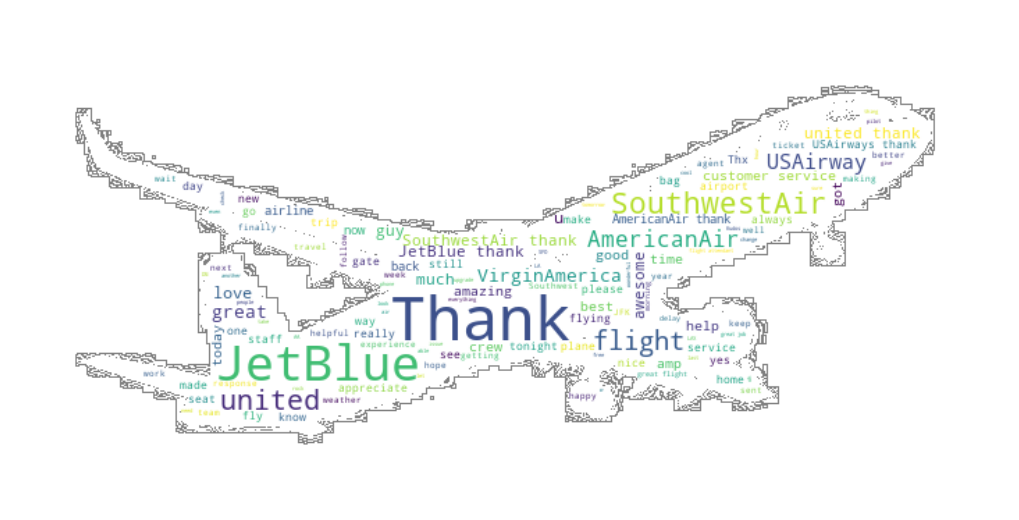

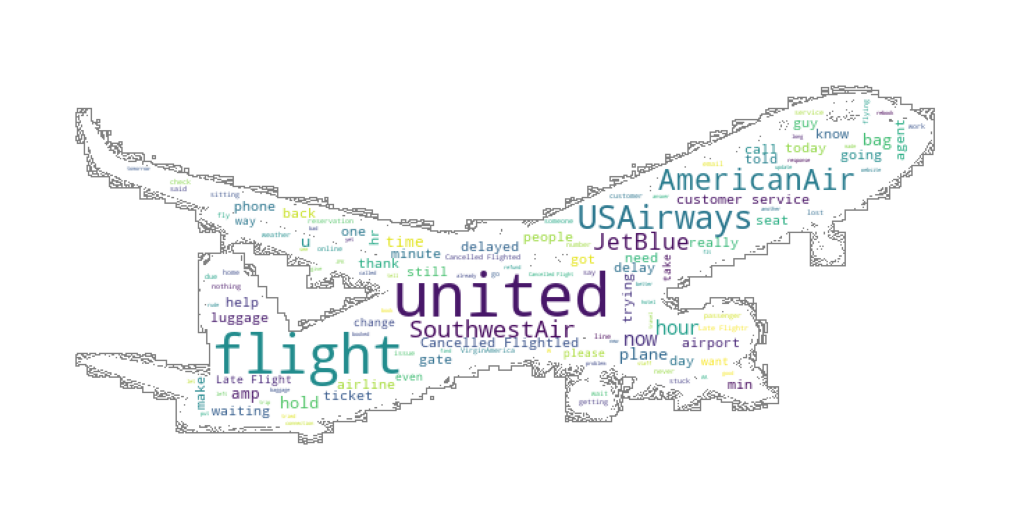

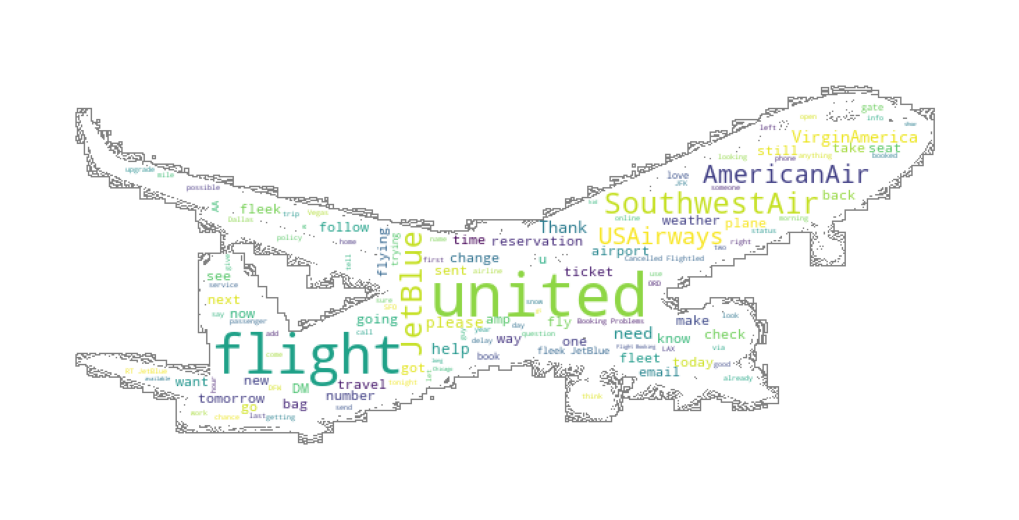

In [51]:
tweet_list_pos = tweets.loc[tweets["airline_sentiment"] == "positive", "text"]

all_tweets_pos = " ".join(tweet_list_pos)
all_tweets_pos = talk_clean_to_me(all_tweets_pos)

# Create a WordCloud object
wordcloud_im_pos = WordCloud(
    stopwords=stopwords,
    background_color="white", 
    mode='RGB',
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    width=1000,
    height=1000,
    max_words=125,
).generate(all_tweets_pos)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_pos, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


### Negative

tweet_list_neg = tweets.loc[tweets["airline_sentiment"] == "negative", "text"]

all_tweets_neg = " ".join(tweet_list_neg)

# Create a WordCloud object
wordcloud_im_neg = WordCloud(
    stopwords=stopwords,
    background_color="white", 
    mode='RGB',  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neg)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neg)
plt.axis("off")
plt.tight_layout(pad=0)

### Neutral
tweet_list_neu = tweets.loc[tweets["airline_sentiment"] == "neutral", "text"]

all_tweets_neu = " ".join(tweet_list_neu)

# Create a WordCloud object
wordcloud_im_neu = WordCloud(
    stopwords=stopwords,
    background_color="white", 
    mode='RGB',  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neu)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neu)
plt.axis("off")
plt.tight_layout(pad=0)

In [53]:

wordcloud_im_pos = remove_background_from_wordcloud(wordcloud_im_pos, background_color=(255, 255, 255)) 
wordcloud_im_neu = remove_background_from_wordcloud(wordcloud_im_neu, background_color=(255, 255, 255)) 
wordcloud_im_neg = remove_background_from_wordcloud(wordcloud_im_neg, background_color=(255, 255, 255)) 

""" plt.figure(figsize=(10, 10)) #, facecolor=None)
plt.imshow(transparent_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0) """



wordcloud_im_pos.save("wordcloud_im_pos.png", format="PNG")
wordcloud_im_neu.save("wordcloud_im_neu.png", format="PNG")
wordcloud_im_neg.save("wordcloud_im_neg.png", format="PNG")

# Classification

### Binary Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

# Only getting Binary labels
X = vectorizer.fit_transform(tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'text'])
y = tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Positive"], y_test, y_pred)


In [ ]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = model.coef_[0]

# Create a mapping of words to their coefficients
word_importance = dict(zip(feature_names, coefficients))

# Sort words by the absolute values of their coefficients
sorted_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the most influential words
#for word, coef in sorted_words[:10]:  # Adjust the number to display as needed
#    print(f"{word}: {coef}")

    # Sort words by the absolute values of their coefficients
sorted_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Convert the sorted words and coefficients into a DataFrame
df_word_importance = pd.DataFrame(sorted_words, columns=['Word', 'Coefficient'])

# Display the DataFrame
print(df_word_importance.head(10))  # Adjust the number to display as needed

      Word  Coefficient
0   thanks     8.335329
1    thank     8.332756
2    great     5.493345
3     love     4.318089
4  awesome     4.211748
5      not    -4.029247
6     best     3.905758
7       no    -3.718366
8  jetblue     3.492744
9  amazing     3.375404


### Logistic Regression with L1 Penalty

In [ ]:
### FINDING THE OPTIMAL VALUE OF LAMBDA

""" # 'liblinear' is a good choice for small datasets, while 'saga' is faster for larger ones
model = LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter = 20000)


# Define the parameter grid
#param_grid = {'C': [0.01, 0.1, 1, 5, 10]}
#param_grid = {'C': [1,2,3,4,5,6,7,8]}
param_grid = {'C': np.arange(2.0,4.0, 0.05)}

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')  # cv is the number of folds

# Perform grid search
grid_search.fit(X_train, y_train)

print("Best C:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Best value of lambda so far is 3.6 """

' # \'liblinear\' is a good choice for small datasets, while \'saga\' is faster for larger ones\nmodel = LogisticRegression(penalty=\'l1\', solver=\'saga\', random_state=42, max_iter = 20000)\n\n\n# Define the parameter grid\n#param_grid = {\'C\': [0.01, 0.1, 1, 5, 10]}\n#param_grid = {\'C\': [1,2,3,4,5,6,7,8]}\nparam_grid = {\'C\': np.arange(2.0,4.0, 0.05)}\n\n# Set up GridSearchCV\ngrid_search = GridSearchCV(model, param_grid, cv=3, scoring=\'accuracy\')  # cv is the number of folds\n\n# Perform grid search\ngrid_search.fit(X_train, y_train)\n\nprint("Best C:", grid_search.best_params_)\nprint("Best score:", grid_search.best_score_)\n\n# Best value of lambda so far is 3.6 '

In [ ]:
model = LogisticRegression(
    penalty="l1",
    solver="saga",
    C= 3.6, #np.round(grid_search.best_params_["C"], 3),
    random_state=42,
    max_iter=20000,
)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Positive"], y_test, y_pred)

In [ ]:
# Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {feature: coef for feature, coef in feature_importance.items() if coef != 0}

# Convert to DataFrame
df_significant_features = pd.DataFrame(list(significant_features.items()), columns=['Feature', 'Coefficient'])

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(df_significant_features['Coefficient'].abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
print(df_significant_features.head(20))


         Feature  Coefficient
742        thank    17.504925
744       thanks    15.587954
869        worst   -14.758955
743     thankful    13.748369
425        kudos    12.917569
385        hours   -12.116464
256    excellent    12.082557
866      worries    11.650291
342        great    11.539834
860    wonderful    11.334984
639         rude   -10.644177
147   charleston    10.359491
89       awesome    10.232393
458         love    10.110791
258  exceptional     9.704872
583     pleasure     9.619496
527          not    -8.908079
465      luggage    -8.571307
460        loved     8.269170
105         best     8.161811


Since we are doing prediction, instead of inference, the below code can technically be ignored. 

In [ ]:
#X.toarray().shape
#df_significant_features["Feature"]

# Extract only the significant features
#significant_feature_names = list(significant_features.keys())

# Assuming 'vectorizer' is your original vectorizer and 'X' is the original feature matrix
#X_filtered = X[:, vectorizer.get_feature_names_out().isin(significant_feature_names)]
#X_filtered

#X_filtered = X[:, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)]

In [ ]:
### Now we use the standard Logistic regression model only using the words chosen by LASSO

# Filter the original feature matrix
#X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
#    X_filtered, y, test_size=0.2, random_state=42
#)

# Initialize the logistic regression model
#model_filtered = LogisticRegression(random_state=42)

# Train the model
#model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
#y_pred = model_filtered.predict(X_test_filtered)

# Evaluate the model
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

In [ ]:
#import statsmodels.api as sm
#from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains categorical labels like 'positive', 'negative'
# Assuming X_train and y_train are your features and target variable

# Initialize the LabelEncoder
#label_encoder = LabelEncoder()

# Fit and transform the labels to numeric
#y_train_encoded = label_encoder.fit_transform(y_train)

# Convert the sparse matrix to a dense array
#X_train_dense = X_train.toarray()

# Add a constant to the features
#X_train_sm = sm.add_constant(X_train_dense)

# Fit the model
#model_sm = sm.Logit(y_train_encoded, X_train_sm).fit()

# Display the summary
#print(model_sm.summary())

### Logistic Regression with Elastic Net Penalty

In [ ]:
""" model = LogisticRegression(
    penalty="elasticnet", solver="saga", random_state=42, max_iter = 20000
)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

param_grid = {
    'C': np.arange(5, 7, 0.25),
    'l1_ratio': np.arange(0.0, 0.5, 0.05)
}

# Parallel Processing
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)  # cv is the number of folds

# Perform grid search
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Best Parameters: {'C': 6.25, 'l1_ratio': 0.35000000000000003} """

' model = LogisticRegression(\n    penalty="elasticnet", solver="saga", random_state=42, max_iter = 20000\n)\n\nparam_grid = {\n    \'C\': [0.01, 0.1, 1, 10, 100],\n    \'l1_ratio\': [0.0, 0.25, 0.5, 0.75, 1.0]\n}\n\nparam_grid = {\n    \'C\': np.arange(5, 7, 0.25),\n    \'l1_ratio\': np.arange(0.0, 0.5, 0.05)\n}\n\n# Parallel Processing\ngrid_search = GridSearchCV(model, param_grid, cv=3, scoring=\'accuracy\', n_jobs=-1)  # cv is the number of folds\n\n# Perform grid search\ngrid_search.fit(X_train, y_train)\n\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Score:", grid_search.best_score_)\n\n# Best Parameters: {\'C\': 6.25, \'l1_ratio\': 0.35000000000000003} '

In [ ]:
""" model = LogisticRegression(
    penalty="elasticnet",
    l1_ratio= 0.35, #grid_search.best_params_["l1_ratio"],
    C= 6.25, #grid_search.best_params_["C"],
    solver="saga",
    random_state=42,
)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_table(cm, ["Negative", "Neutral", "Positive"])

plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()
display(report_df) """

' model = LogisticRegression(\n    penalty="elasticnet",\n    l1_ratio= 0.35, #grid_search.best_params_["l1_ratio"],\n    C= 6.25, #grid_search.best_params_["C"],\n    solver="saga",\n    random_state=42,\n)\n\n# Fit the model\nmodel.fit(X_train, y_train)\n\n# Predict on the test set\ny_pred = model.predict(X_test)\n\n# Evaluate the model\nprint("Accuracy:", accuracy_score(y_test, y_pred))\n#print(classification_report(y_test, y_pred))\n\ncm = confusion_matrix(y_test, y_pred)\nplot_confusion_matrix_with_table(cm, ["Negative", "Neutral", "Positive"])\n\nplot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)\n\n# Generate a classification report\nreport = classification_report(y_test, y_pred, output_dict=True)\n\n# Convert the report to a DataFrame\nreport_df = pd.DataFrame(report).transpose()\ndisplay(report_df) '

In [ ]:
""" # Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {
    feature: coef for feature, coef in feature_importance.items() if coef != 0
}

# Convert to DataFrame
df_significant_features = pd.DataFrame(
    list(significant_features.items()), columns=["Feature", "Coefficient"]
)

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(
    df_significant_features["Coefficient"].abs().sort_values(ascending=False).index
)

# Display the sorted DataFrame
print(df_significant_features.head(10)) """

' # Get the coefficients\ncoefficients = model.coef_[0]\n\n# Map coefficients to features\nfeature_importance = dict(zip(feature_names, coefficients))\n\n# Filter out features with zero coefficients\nsignificant_features = {\n    feature: coef for feature, coef in feature_importance.items() if coef != 0\n}\n\n# Convert to DataFrame\ndf_significant_features = pd.DataFrame(\n    list(significant_features.items()), columns=["Feature", "Coefficient"]\n)\n\n# Order by the absolute value of the coefficients\ndf_significant_features = df_significant_features.reindex(\n    df_significant_features["Coefficient"].abs().sort_values(ascending=False).index\n)\n\n# Display the sorted DataFrame\nprint(df_significant_features.head(10)) '

In [ ]:
""" # Extract only the significant features
significant_feature_names = list(significant_features.keys())

X_filtered = X[
    :, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)
]

## Now we use the standard Logistic regression model only using the words chosen by Elastic Net

# Filter the original feature matrix
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
model_filtered = LogisticRegression(random_state=42)

# Train the model
model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = model_filtered.predict(X_test_filtered)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) """

' # Extract only the significant features\nsignificant_feature_names = list(significant_features.keys())\n\nX_filtered = X[\n    :, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)\n]\n\n## Now we use the standard Logistic regression model only using the words chosen by Elastic Net\n\n# Filter the original feature matrix\nX_train_filtered, X_test_filtered, y_train, y_test = train_test_split(\n    X_filtered, y, test_size=0.2, random_state=42\n)\n\n# Initialize the logistic regression model\nmodel_filtered = LogisticRegression(random_state=42)\n\n# Train the model\nmodel_filtered.fit(X_train_filtered, y_train)\n\n# Predict on the test set\ny_pred = model_filtered.predict(X_test_filtered)\n\n# Evaluate the model\nprint("Accuracy:", accuracy_score(y_test, y_pred))\nprint(classification_report(y_test, y_pred)) '

### Logistic Regression with N-Grams

In [ ]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True, ngram_range=(1,2))

# Only getting Binary labels
X = vectorizer.fit_transform(tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'text'])
y = tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Positive"], y_test, y_pred)

#### N-Gram LASSO

In [ ]:
# 'liblinear' is a good choice for small datasets, while 'saga' is faster for larger ones
model = LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter= 20000)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Positive"], y_test, y_pred)

In [ ]:
# Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {
    feature: coef for feature, coef in feature_importance.items() if coef != 0
}

# Convert to DataFrame
df_significant_features = pd.DataFrame(
    list(significant_features.items()), columns=["Feature", "Coefficient"]
)

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(
    df_significant_features["Coefficient"].abs().sort_values(ascending=False).index
)

# Display the sorted DataFrame
print(df_significant_features.head(10))


# Extract only the significant features
significant_feature_names = list(significant_features.keys())

X_filtered = X[
    :, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)
]

### Now we use the standard Logistic regression model only using the words chosen by LASSO

# Filter the original feature matrix
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
model_filtered = LogisticRegression(random_state=42)

# Train the model
model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = model_filtered.predict(X_test_filtered)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

         Feature  Coefficient
19            fb    10.532439
59        status     9.270402
11        bummer     8.883485
37          like    -8.187085
27         hates     7.961943
48         price    -6.310221
15  disconnected     5.881800
61        stinks     5.544731
36          life     5.366972
50          race     4.900342
Accuracy: 0.8016710642040458
              precision    recall  f1-score   support

    negative       0.80      1.00      0.89      1822
    positive       1.00      0.00      0.00       452

    accuracy                           0.80      2274
   macro avg       0.90      0.50      0.45      2274
weighted avg       0.84      0.80      0.71      2274



### Logistic Regression with Combined Positive and Neutral Class to Address Class Imbalance

In [ ]:
# Trying to combine labels of positive and neutral
tweets_comb = tweets.copy()
tweets_comb["airline_sentiment"] = tweets_comb["airline_sentiment"].replace(
    {"neutral": "positive + neutral", "positive": "positive + neutral"}
)

### Standard Logistic Regression

In [ ]:
# Only getting Binary labels
X = vectorizer.fit_transform(tweets_comb['text'])
y = tweets_comb['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8361111111111111
                    precision    recall  f1-score   support

          negative       0.83      0.93      0.88      1791
positive + neutral       0.85      0.69      0.76      1089

          accuracy                           0.84      2880
         macro avg       0.84      0.81      0.82      2880
      weighted avg       0.84      0.84      0.83      2880



Less accuracy does not make this of interest to pursuit, might revisit in the future. 

### Multinomial Regression 

In [ ]:
# Only getting Trinary labels
X = vectorizer.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 42, max_iter=20000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
#print("Accuracy:", accuracy_score(y_test, predictions))
#print(classification_report(y_test, predictions))

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)


### Multinomial Logistic Regression with L1 Penalty

In [ ]:
""" model = LogisticRegression(
    penalty="l1", multi_class = "multinomial", solver="saga", random_state=42, max_iter = 20000
)

#param_grid = {
#    'C': np.arange(3.5, 3.75, 0.05),
#}

param_grid = {
    'C':np.arange(1.3, 1.5, 0.01)
}

# Parallel Processing
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)  # cv is the number of folds

# Perform grid search
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 1st round C:1
# 2nd Round 1.4
# 3rd Round Best Parameters: {'C': 1.4700000000000002} """

Best Parameters: {'C': 1.4700000000000002}
Best Score: 0.7941304159069201


In [ ]:
# Train model
model = LogisticRegression(
    penalty="l1",
    C= 1.47, #grid_search.best_params_["C"],
    multi_class="multinomial",
    solver="saga",
    random_state=42,
    max_iter=20000,
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)

Accuracy: 0.7944444444444444
              precision    recall  f1-score   support

    negative       0.83      0.92      0.87      1791
     neutral       0.67      0.54      0.60       636
    positive       0.78      0.65      0.71       453

    accuracy                           0.79      2880
   macro avg       0.76      0.70      0.73      2880
weighted avg       0.79      0.79      0.79      2880



### Multinomial Logistic Regression with Elastic Net

In [ ]:
""" model = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    multi_class="multinomial",
    random_state=42,
    max_iter=15000,
)

#param_grid = {"C": [0.01, 0.1, 1, 10, 100], "l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]}
param_grid = {"C": np.arange(1.435, 1.445, 0.001), "l1_ratio": np.arange(0.05, 0.055, 0.001)}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 1st round, C: 1, l1_ratio: 0
# 2nd round: Best Parameters: {'C': 1.2999999999999998, 'l1_ratio': 0.05}
# 3rd Round: Best Parameters: {'C': 1.4500000000000004, 'l1_ratio': 0.05}
# 4th Round: Best Parameters: {'C': 1.44, 'l1_ratio': 0.051000000000000004}
# 5th Round {'C': 1.4369999999999998, 'l1_ratio': 0.052000000000000005} """


Best Parameters: {'C': 1.4369999999999998, 'l1_ratio': 0.052000000000000005}
Best Cross-Validation Score: 0.799166449596249


In [ ]:
model = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    multi_class="multinomial",
    C =  1.437, #grid_search.best_params_["C"],
    l1_ratio =  0.052, #grid_search.best_params_["l1_ratio"],
    random_state=42,
    max_iter=15000,
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)

Accuracy: 0.796875
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88      1791
     neutral       0.67      0.54      0.60       636
    positive       0.81      0.62      0.70       453

    accuracy                           0.80      2880
   macro avg       0.77      0.70      0.72      2880
weighted avg       0.79      0.80      0.79      2880



### Multinomial Logistic Regression with N-Grams 

In [ ]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True, ngram_range=(1,2))

# Only getting Trinary labels
X = vectorizer.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train model
model = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 42, max_iter=20000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)

Accuracy: 0.7989583333333333
              precision    recall  f1-score   support

    negative       0.80      0.96      0.87      1791
     neutral       0.74      0.50      0.60       636
    positive       0.85      0.59      0.69       453

    accuracy                           0.80      2880
   macro avg       0.80      0.68      0.72      2880
weighted avg       0.80      0.80      0.79      2880



### N-Gram Multi Lasso

In [ ]:
""" model = LogisticRegression(
    penalty="l1", multi_class = "multinomial", solver="saga", random_state=42, max_iter = 20000
)

#param_grid = {
#    'C': np.arange(3.5, 3.75, 0.05),
#}

param_grid = {
    'C':np.arange(1.3, 1.4, 0.01)
}

# Parallel Processing
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)  # cv is the number of folds

# Perform grid search
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 1st Round Best Parameters: {'C': 1}
# 2nd Round Best Parameters: {'C': 1.4}
# 3rd Round Best Parameters: {'C': 1.3}
# 4th Round Best Parameters: {'C': 1.31}
# 5th Round Best Parameters: {'C': 1.3900000000000001} """

Best Parameters: {'C': 1.3900000000000001}
Best Score: 0.7908309455587393


In [ ]:
# Train model
model = LogisticRegression(
    penalty="l1",
    C= 1.39, #grid_search.best_params_["C"],
    multi_class="multinomial",
    solver="saga",
    random_state=42,
    max_iter=20000,
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)

Accuracy: 0.7878472222222223
              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1791
     neutral       0.67      0.52      0.59       636
    positive       0.79      0.63      0.70       453

    accuracy                           0.79      2880
   macro avg       0.76      0.69      0.72      2880
weighted avg       0.78      0.79      0.78      2880



### N-Gram Multi Elastic Net

In [ ]:
""" model = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    multi_class="multinomial",
    random_state=42,
    max_iter=15000,
)

#param_grid = {"C": [0.01, 0.1, 1, 10, 15], "l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]}
param_grid = {"C": np.arange(4.5, 5.5, 0.25), "l1_ratio": np.arange(0.03, 0.05, 0.005)}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 1st Round Best Parameters: {'C': 10, 'l1_ratio': 0.0}
# 2nd Round Best Parameters: {'C': 6, 'l1_ratio': 0.0}
# 3rd Round Best Parameters: {'C': 5, 'l1_ratio': 0.04}
# 4th Round Best Parameters: {'C': 5.0, 'l1_ratio': 0.039999999999999994} """

Best Parameters: {'C': 5.0, 'l1_ratio': 0.039999999999999994}
Best Cross-Validation Score: 0.7969957454198142


In [ ]:
# Train model
model = LogisticRegression(
    penalty="elasticnet",
    C= 5.0, #grid_search.best_params_["C"],
    l1_ratio =  0.04,  #grid_search.best_params_["l1_ratio"]
    multi_class="multinomial",
    solver="saga",
    random_state=42,
    max_iter=20000,
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix_with_classification_report(cm, ["Negative", "Neutral", "Positive"], y_test, y_pred)

Accuracy: 0.8017361111111111
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88      1791
     neutral       0.69      0.55      0.62       636
    positive       0.79      0.66      0.72       453

    accuracy                           0.80      2880
   macro avg       0.77      0.71      0.74      2880
weighted avg       0.79      0.80      0.79      2880



### SVM

In [ ]:
# SVM | https://medium.com/scrapehero/sentiment-analysis-using-svm-338d418e3ff1

train_vectors = vectorizer.fit_transform(tweets["text"])
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel="linear")
t0 = time.time()
classifier_linear.fit(train_vectors, tweets["airline_sentiment"])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1 - t0
time_linear_predict = t2 - t1
# results
print(
    "Training time: %fs; Prediction time: %fs"
    % (time_linear_train, time_linear_predict)
)
report = classification_report(testData["Label"], prediction_linear, output_dict=True)
print("positive: ", report["pos"])
print("negative: ", report["neg"])

NameError: name 'test_vectors' is not defined

In [ ]:
# https://www.educative.io/answers/how-to-use-svm-for-sentiment-analysis

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


text = tweets["text"].values
labels = tweets["airline_sentiment"].values

text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels, test_size=0.2, random_state=42
)

vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(text_train)
features_test = vectorizer.transform(text_test)

svm = SVC(kernel="linear")
svm.fit(features_train, labels_train)

predictions = svm.predict(features_test)
new_text = [
    "I hate Devin Booker",
    "Thai Canteen has awful service.",
    "The new Titebond glue is amazing.",
]
new_features = vectorizer.transform(new_text)
new_predictions = svm.predict(new_features)
print(new_predictions)

# Step 7: Generate the classification report to evaluate the model
print(classification_report(labels_test, predictions))

['negative' 'neutral' 'positive']
              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      1889
     neutral       0.58      0.56      0.57       580
    positive       0.70      0.71      0.71       459

    accuracy                           0.78      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.78      0.78      0.78      2928



In [ ]:
# https://www.kaggle.com/code/lbronchal/sentiment-analysis-with-svm

data_clean = tweets[tweets["airline_sentiment_confidence"] > 0.65]
data_clean["sentiment"] = data_clean["airline_sentiment"].apply(
    lambda x: 1 if x == "negative" else 0
)

data_clean["text_clean"] = data_clean["text"].apply(
    lambda x: BeautifulSoup(x, "lxml").text
)